In [6]:
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras import backend as K
from keras.objectives import binary_crossentropy

In [56]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
intermediate_dim = 256
latent_dim = 2
batch_size = 100
nb_epoch = 100
noise_std = .01
n_pixels=28*28

x = Input(shape=(n_pixels,))
h = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [21]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=0.01)
    return z_mean + K.exp(z_log_sigma) * epsilon
# what is the Lambda function 
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [23]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(n_pixels, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [25]:
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


In [29]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [30]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [33]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s - loss: 0.2927 - val_loss: 0.2427
Epoch 2/100
60000/60000 [==============================] - 11s - loss: 0.2350 - val_loss: 0.2286
Epoch 3/100
60000/60000 [==============================] - 12s - loss: 0.2247 - val_loss: 0.2221
Epoch 4/100
60000/60000 [==============================] - 12s - loss: 0.2197 - val_loss: 0.2172
Epoch 5/100
60000/60000 [==============================] - 13s - loss: 0.2154 - val_loss: 0.2141
Epoch 6/100
60000/60000 [==============================] - 13s - loss: 0.2129 - val_loss: 0.2126
Epoch 7/100
60000/60000 [==============================] - 12s - loss: 0.2114 - val_loss: 0.2114
Epoch 8/100
60000/60000 [==============================] - 12s - loss: 0.2104 - val_loss: 0.2100
Epoch 9/100
60000/60000 [==============================] - 13s - loss: 0.2096 - val_loss: 0.2099
Epoch 10/100
60000/60000 [==============================] - 13s - loss: 0.2088

60000/60000 [==============================] - 13s - loss: 0.1965 - val_loss: 0.1993
Epoch 85/100
60000/60000 [==============================] - 13s - loss: 0.1965 - val_loss: 0.1978
Epoch 86/100
60000/60000 [==============================] - 13s - loss: 0.1964 - val_loss: 0.1975
Epoch 87/100
60000/60000 [==============================] - 13s - loss: 0.1964 - val_loss: 0.1982
Epoch 88/100
60000/60000 [==============================] - 13s - loss: 0.1964 - val_loss: 0.1973
Epoch 89/100
60000/60000 [==============================] - 13s - loss: 0.1963 - val_loss: 0.1982
Epoch 90/100
60000/60000 [==============================] - 13s - loss: 0.1963 - val_loss: 0.1967
Epoch 91/100
60000/60000 [==============================] - 13s - loss: 0.1962 - val_loss: 0.1989
Epoch 92/100
60000/60000 [==============================] - 13s - loss: 0.1961 - val_loss: 0.1974
Epoch 93/100
60000/60000 [==============================] - 13s - loss: 0.1961 - val_loss: 0.1971
Epoch 94/100
60000/60000 [=======

In [35]:
h.eval({x:x_test}).shape

(10000, 256)

In [37]:
z_mean.eval({x:x_test}).shape

(10000, 2)

In [42]:
z_log_var.eval({x:x_test})[0]

array([-0.01906404, -0.0146087 ], dtype=float32)

In [41]:
z

Elemwise{add,no_inplace}.0

In [43]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [44]:
x_test_encoded.shape

(10000, 2)

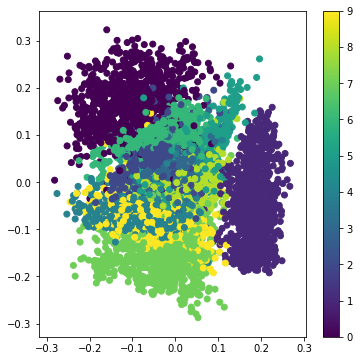

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()


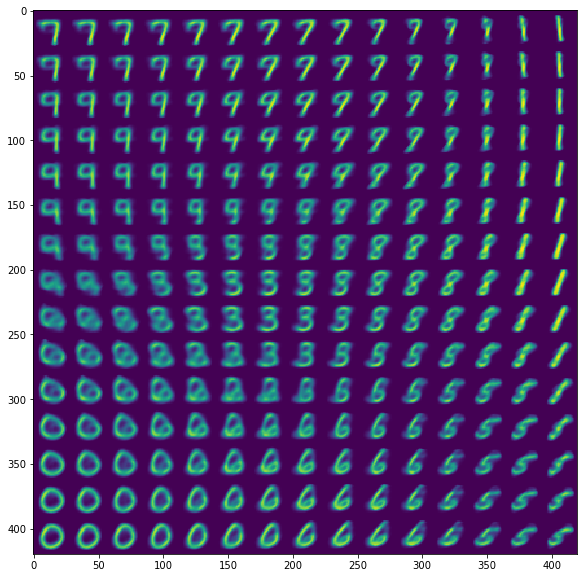

In [54]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])* 0.01
        #print(z_sample)
        #x_decoded = generator.predict(z_sample)
        x_decoded=_x_decoded_mean.eval({decoder_input:z_sample.astype('float32')})
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [57]:
z_sample.shape

(1, 2)